In [7]:
import numpy as np
import pandas as pd
import pickle
from kdg.utils import trunk_sim, hellinger, plot_2dsim, sample_unifrom_circle
from kdg import kdn, kdf
from tensorflow import keras
from tensorflow.keras import activations
from joblib import Parallel, delayed
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

<AxesSubplot: >

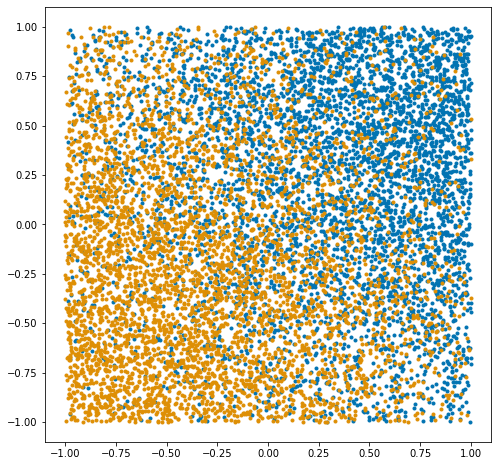

In [8]:
X, y = trunk_sim(10000, p_star=2, p=2)
plot_2dsim(X,y)

In [9]:
def get_trunk_posterior(x, p=2):
    mean = 1.0 / np.sqrt(np.arange(1, p + 1, 1))
    class1_likelihood = 0
    class2_likelihood = 0
    for ii in range(p):
        class1_likelihood += -(x[:,ii]-mean[ii])**2/(2) - .5*np.log(2*np.pi)
        class2_likelihood += -(x[:,ii]+mean[ii])**2/(2) - .5*np.log(2*np.pi)
    
    class1_likelihood = class1_likelihood.reshape(-1,1)
    class2_likelihood = class2_likelihood.reshape(-1,1)
    
    total_likelihood = np.concatenate((class1_likelihood,class2_likelihood),axis=1)
    max_likelihood = np.max(total_likelihood, axis=1).reshape(-1,1)
    class1_likelihood = np.exp(class1_likelihood-max_likelihood)
    class2_likelihood = np.exp(class2_likelihood-max_likelihood)
    
    posterior = np.hstack((class1_likelihood/(class1_likelihood+class2_likelihood),class1_likelihood/(class1_likelihood+class2_likelihood)))
                               
    return posterior

In [16]:
def getNN(input_size, num_classes, layer_size=1000):
    network_base = keras.Sequential()
    initializer = keras.initializers.random_normal(seed=0)
    network_base.add(keras.layers.Dense(layer_size, kernel_initializer=initializer, input_shape=(input_size,)))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(layer_size, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(layer_size, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(layer_size, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(units=num_classes, activation="softmax", kernel_initializer=initializer))
    network_base.compile(**compile_kwargs)
    return network_base

In [17]:
compile_kwargs = {
        "loss": "binary_crossentropy",
        "optimizer": keras.optimizers.Adam(3e-4),
    }
callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10, verbose=True)
fit_kwargs = {
        "epochs": 200,
        "batch_size": 32,
        "verbose": False,
        "callbacks": [callback],
    }

In [12]:
df = {}
model_kdf = kdf(kwargs={'n_estimators':500})
model_kdf.fit(X, y)
model_kdf.global_bias = -1e2

#define grids
p = np.arange(-2, 2, step=0.01)
q = np.arange(-2, 2, step=0.01)
xx, yy = np.meshgrid(p, q)

grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)
posterior_rf = model_kdf.rf_model.predict_proba(grid_samples)
posterior_kdf, likelihoods_kdf = model_kdf.predict_proba(grid_samples, return_likelihood=True)
posterior_kdf_geod, likelihoods_kdf_geod = model_kdf.predict_proba(grid_samples, distance='Geodesic', return_likelihood=True)


posterior_rf = posterior_rf[:,0].reshape(400,400)
posterior_kdf = posterior_kdf[:,0].reshape(400,400)
class1_likelihoods_kdf = likelihoods_kdf[:,0].reshape(400,400)
class2_likelihoods_kdf = likelihoods_kdf[:,1].reshape(400,400)

posterior_kdf_geod = posterior_kdf_geod[:,0].reshape(400,400)
class1_likelihoods_geod_kdf = likelihoods_kdf_geod[:,0].reshape(400,400)
class2_likelihoods_geod_kdf = likelihoods_kdf_geod[:,1].reshape(400,400)

df['posterior_rf'] = posterior_rf
df['posterior_kdf'] = posterior_kdf
df['likelihood_class1_kdf'] = class1_likelihoods_kdf
df['likelihood_class2_kdf'] = class2_likelihoods_kdf
df['posterior_kdf_geod'] = posterior_kdf_geod
df['likelihood_class1_geod_kdf'] = class1_likelihoods_geod_kdf
df['likelihood_class2_geod_kdf'] = class2_likelihoods_geod_kdf

In [36]:
#define grids
p = np.arange(-2, 2, step=0.01)
q = np.arange(-2, 2, step=0.01)
xx, yy = np.meshgrid(p, q)

grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

nn = getNN(
            input_size=X.shape[1],
            num_classes=2, 
            layer_size=100
        )
history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
model_kdn = kdn(network=nn)
model_kdn.fit(X, y)

model_kdn.global_bias = -1e100
posterior_dn = model_kdn.network.predict(grid_samples)
posterior_kdn, likelihoods_kdn = model_kdn.predict_proba(grid_samples, return_likelihood=True)
posterior_kdn_geod, likelihoods_kdn_geod = model_kdn.predict_proba(grid_samples, distance='Geodesic', return_likelihood=True)

posterior_dn = posterior_dn[:,0].reshape(400,400)
posterior_kdn = posterior_kdn[:,0].reshape(400,400)
class1_likelihoods_kdn = likelihoods_kdn[:,0].reshape(400,400)
class2_likelihoods_kdn = likelihoods_kdn[:,1].reshape(400,400)

posterior_kdn_geod = posterior_kdn_geod[:,0].reshape(400,400)
class1_likelihoods_geod_kdn = likelihoods_kdn_geod[:,0].reshape(400,400)
class2_likelihoods_geod_kdn = likelihoods_kdn_geod[:,1].reshape(400,400)


df['posterior_dn'] = posterior_dn
df['posterior_kdn'] = posterior_kdn
df['likelihood_class1_kdn'] = class1_likelihoods_kdn
df['likelihood_class2_kdn'] = class2_likelihoods_kdn
df['posterior_kdn_geod'] = posterior_kdn_geod
df['likelihood_class1_geod_kdn'] = class1_likelihoods_geod_kdn
df['likelihood_class2_geod_kdn'] = class2_likelihoods_geod_kdn

2023-10-02 14:22:43.376845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 20: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.74s/it]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2175.64it/s]

   1/5000 [..............................] - ETA: 3:22


2023-10-02 14:23:31.746687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5000/5000 [==============================] - 9s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.92s/it]


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


In [47]:
p = np.arange(-1, 1, step=0.01)
q = np.arange(-1, 1, step=0.01)
xx, yy = np.meshgrid(p, q)

grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)
proba_true = 0.5*np.ones((400, 400))
tmp = get_trunk_posterior(grid_samples)[:,0]

proba_true[100:300, 100:300] = tmp.reshape(200, 200)

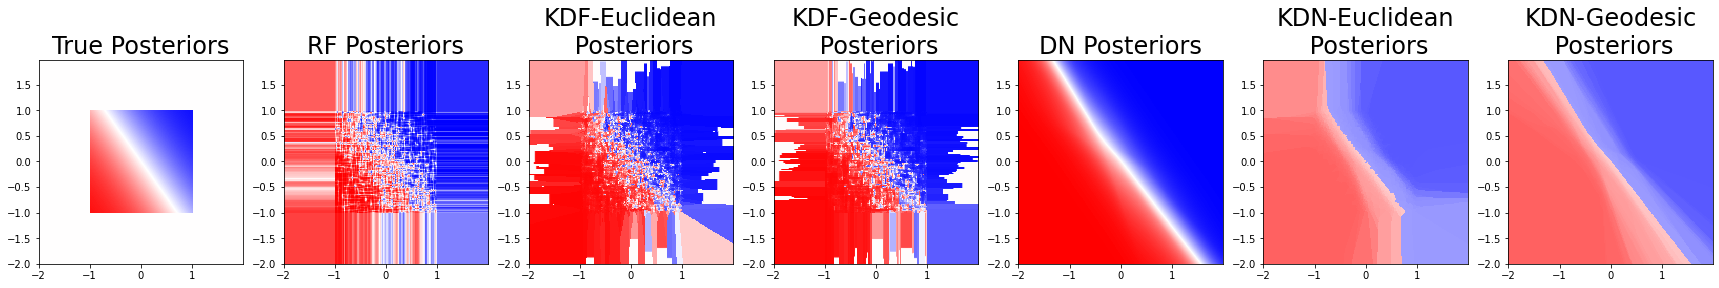

In [82]:
fig1, ax = plt.subplots(1, 7, figsize=(30, 210))

p = np.arange(-2, 2, step=0.01)
q = np.arange(-2, 2, step=0.01)
xx, yy = np.meshgrid(p, q)

ax0 = ax[0].imshow(
    np.fliplr(proba_true),
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[0].set_title("True Posteriors", fontsize=24)
ax[0].set_aspect("equal")

ax1 = ax[1].imshow(
    np.fliplr(posterior_rf),
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("RF Posteriors", fontsize=24)
ax[1].set_aspect("equal")

ax2 = ax[2].imshow(
    np.fliplr(posterior_kdf),
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[2].set_title("KDF-Euclidean\n Posteriors", fontsize=24)
ax[2].set_aspect("equal")

ax2 = ax[3].imshow(
    np.fliplr(posterior_kdf_geod),
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[3].set_title("KDF-Geodesic\n Posteriors", fontsize=24)
ax[3].set_aspect("equal")

ax1 = ax[4].imshow(
    np.fliplr(posterior_dn),
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[4].set_title("DN Posteriors", fontsize=24)
ax[4].set_aspect("equal")

ax2 = ax[5].imshow(
    np.fliplr(posterior_kdn),
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[5].set_title("KDN-Euclidean\n Posteriors", fontsize=24)
ax[5].set_aspect("equal")

ax2 = ax[6].imshow(
    np.fliplr(posterior_kdn_geod),
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[6].set_title("KDN-Geodesic\n Posteriors", fontsize=24)
ax[6].set_aspect("equal")
plt.show()

In [41]:
# %%
##### main hyperparameters #####
mc_reps = 10
signal_dimension = [1, 10, 100, 200, 400, 600, 800, 1000]
train_sample = 5000
test_sample = 1000

In [42]:
def experiment(dim):
    X, y = trunk_sim(train_sample, p_star=dim, p=dim)
    X_test, y_test = trunk_sim(test_sample, p_star=dim, p=dim)
    true_posterior = get_trunk_posterior(X_test,p=dim)

    model_kdf = kdf(kwargs={'n_estimators':500})
    model_kdf.fit(X, y)

    nn = getNN(
            input_size=X.shape[1],
            num_classes=2, 
            layer_size=100
        )
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    model_kdn = kdn(network=nn)
    model_kdn.fit(X, y)
    
    proba_kdf = model_kdf.predict_proba(X_test)
    proba_kdf_geodesic = model_kdf.predict_proba(X_test, distance='Geodesic')
    proba_kdn = model_kdn.predict_proba(X_test)
    proba_kdn_geodesic = model_kdn.predict_proba(X_test, distance='Geodesic')
    proba_rf = model_kdf.rf_model.predict_proba(X_test)
    proba_dn = model_kdn.network.predict(X_test)
    
    kdf_err = 1 - \
        np.mean(np.argmax(proba_kdf,axis=1)==y_test)
    kdf_err_geodesic = 1 - \
        np.mean(np.argmax(proba_kdf_geodesic,axis=1)==y_test)
    
    kdf_hellinger = hellinger(
                        true_posterior,
                        proba_kdf
                    )
    kdf_geodesic_hellinger = hellinger(
                        true_posterior,
                        proba_kdf_geodesic
                    )
    
    
    kdn_err = 1 - \
        np.mean(np.argmax(proba_kdn,axis=1)==y_test)
    kdn_err_geodesic = 1 - \
        np.mean(np.argmax(proba_kdn_geodesic,axis=1)==y_test)
    
    kdn_hellinger = hellinger(
                        true_posterior,
                        proba_kdn
                    )
    kdn_geodesic_hellinger = hellinger(
                        true_posterior,
                        proba_kdn_geodesic
                    )
    
    rf_err = 1 - \
        np.mean(np.argmax(proba_rf,axis=1)==y_test)
    dn_err = 1 - \
        np.mean(np.argmax(proba_dn,axis=1)==y_test)
    
    rf_hellinger = hellinger(
                        true_posterior,
                        proba_rf
                    )
    dn_geodesic_hellinger = hellinger(
                        true_posterior,
                        proba_dn
                    )
    
    #print(kdn_err, kdn_err_geodesic, kdf_err, kdf_err_geodesic, rf_err, dn_err, kdn_hellinger, kdn_geodesic_hellinger, kdf_hellinger, kdf_geodesic_hellinger, rf_hellinger, dn_geodesic_hellinger)
    return kdn_err, kdn_err_geodesic, kdf_err, kdf_err_geodesic, rf_err, dn_err, kdn_hellinger, kdn_geodesic_hellinger, kdf_hellinger, kdf_geodesic_hellinger, rf_hellinger, dn_geodesic_hellinger


In [43]:
err_kdn = []
err_kdf = []
err_dn = []
err_rf = []
err_kdf_geodesic = []
err_kdn_geodesic = []
hel_kdn = []
hel_kdf = []
hel_dn = []
hel_rf = []
hel_kdf_geodesic = []
hel_kdn_geodesic = []
dimension = []

for dim in signal_dimension:
    print('doing dim ', dim)
    res = []
    for _ in range(mc_reps):
        res.append(experiment(dim))
    
    for ii in range(mc_reps):
        err_kdn.append(
            res[ii][0]
        )
        err_kdn_geodesic.append(
            res[ii][1]
        )
        err_kdf.append(
            res[ii][2]
        )
        err_kdf_geodesic.append(
            res[ii][3]
        )
        err_rf.append(
            res[ii][4]
        )
        err_dn.append(
            res[ii][5]
        )
        
        hel_kdn.append(
            res[ii][6]
        )
        hel_kdn_geodesic.append(
            res[ii][7]
        )
        hel_kdf.append(
            res[ii][8]
        )
        hel_kdf_geodesic.append(
            res[ii][9]
        )
        hel_rf.append(
            res[ii][10]
        )
        hel_dn.append(
            res[ii][11]
        )
        dimension.append(
            dim
        )

df['err_kdn'] = err_kdn
df['err_kdf'] = err_kdf
df['err_dn'] = err_dn
df['err_rf'] = err_rf
df['err_kdf_geodesic'] = err_kdf_geodesic
df['err_kdn_geodesic'] = err_kdn_geodesic

df['kdn_hellinger'] = hel_kdn
df['kdf_hellinger'] = hel_kdf
df['dn_hellinger'] = hel_dn
df['rf_hellinger'] = hel_rf
df['kdf_geodesic_hellinger'] = hel_kdf_geodesic
df['kdn_geodesic_hellinger'] = hel_kdn_geodesic

df['dimension'] = dimension


doing dim  1


2023-10-02 14:27:50.432759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 36: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.13it/s]


Fitting data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 4972.66it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.47it/s]


30/32 [===========================>..] - ETA: 0s

2023-10-02 14:28:29.614365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-10-02 14:28:50.095004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 26: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.14it/s]


Fitting data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 5029.01it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.12it/s]


27/32 [========================>.....] - ETA: 0s

2023-10-02 14:29:19.967000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-10-02 14:29:39.729644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 40: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.12it/s]


Fitting data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 5058.61it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.39it/s]


28/32 [=========================>....] - ETA: 0s

2023-10-02 14:30:22.140649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-10-02 14:30:42.667871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 20: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.12it/s]


Fitting data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 4963.73it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.65it/s]


25/32 [======================>.......] - ETA: 0s

2023-10-02 14:31:07.732468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-10-02 14:31:27.950921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 41: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.12it/s]


Fitting data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 5023.39it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


18/32 [===============>..............] - ETA: 0s

2023-10-02 14:32:11.155058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-10-02 14:32:30.855264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 24: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.15it/s]


Fitting data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 5100.40it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.63it/s]
2023-10-02 14:32:58.026767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-10-02 14:33:17.768709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 52: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.11it/s]


Fitting data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 5100.89it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.35it/s]
2023-10-02 14:34:08.509919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-10-02 14:34:28.931054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 37: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.11it/s]


Fitting data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 5070.88it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.57it/s]
2023-10-02 14:35:07.350145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-10-02 14:35:27.156467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 40: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.15it/s]


Fitting data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 5096.57it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.60it/s]
2023-10-02 14:36:07.552982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-10-02 14:36:27.854814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 17: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.09it/s]


Fitting data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 5045.04it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.20it/s]
2023-10-02 14:36:49.542034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
doing dim  10


2023-10-02 14:37:12.563462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.16it/s]


Fitting data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2519.31it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


 1/32 [..............................] - ETA: 1s

2023-10-02 14:40:09.098574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-10-02 14:40:31.023124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 193: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.11it/s]


Fitting data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2578.79it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.32it/s]


 1/32 [..............................] - ETA: 1s

2023-10-02 14:43:20.926113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-10-02 14:43:43.165714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.15it/s]


Fitting data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2621.28it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


 1/32 [..............................] - ETA: 1s

2023-10-02 14:46:37.083019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-10-02 14:46:59.352583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 173: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.16it/s]


Fitting data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2612.62it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


 1/32 [..............................] - ETA: 1s

2023-10-02 14:49:32.603247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-10-02 14:49:54.693573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 150: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.15it/s]


Fitting data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 2488.25it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.31it/s]


 1/32 [..............................] - ETA: 1s

2023-10-02 14:52:08.527674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-10-02 14:52:31.051075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 157: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.15it/s]


Fitting data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2551.30it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


 1/32 [..............................] - ETA: 1s

2023-10-02 14:54:50.963267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-10-02 14:55:13.583330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 154: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.09it/s]


Fitting data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2502.51it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


 1/32 [..............................] - ETA: 1s

2023-10-02 14:57:31.588145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-10-02 14:57:53.313790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 162: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.14it/s]


Fitting data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2644.65it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


 1/32 [..............................] - ETA: 1s

2023-10-02 15:00:17.446923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-10-02 15:00:40.689430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 158: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.16it/s]


Fitting data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 2483.70it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]


 1/32 [..............................] - ETA: 1s

2023-10-02 15:03:01.702825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-10-02 15:03:23.724917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 169: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.16it/s]


Fitting data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2515.45it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


 1/32 [..............................] - ETA: 1s

2023-10-02 15:05:53.498759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
doing dim  100


2023-10-02 15:06:28.371490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 176: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.11it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:07<00:00, 646.52it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.32it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 15:09:11.579592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 15:09:45.627884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 179: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.09it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:07<00:00, 628.81it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.29it/s]


32/32 [==============================] - 0s 2ms/step


2023-10-02 15:12:31.624991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 15:13:07.937347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 191: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.12it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:07<00:00, 653.85it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]


32/32 [==============================] - 0s 2ms/step


2023-10-02 15:16:03.395243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 15:16:41.020211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 171: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.14it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:07<00:00, 638.83it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.31it/s]


32/32 [==============================] - 0s 2ms/step


2023-10-02 15:19:21.674434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 15:19:55.726681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 176: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.09it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:07<00:00, 645.10it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


32/32 [==============================] - 0s 2ms/step


2023-10-02 15:22:41.041811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 15:23:16.723151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 171: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.11it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 573.56it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.31it/s]


32/32 [==============================] - 0s 2ms/step


2023-10-02 15:25:59.616148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 15:26:33.874502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 167: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.16it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 561.17it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 15:29:12.935673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 15:29:51.590732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 185: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.15it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 610.81it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.11it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 15:32:52.763323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 15:33:29.383378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 189: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.16it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:07<00:00, 651.00it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.29it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 15:36:26.814651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 15:37:01.121945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 180: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.11it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:07<00:00, 635.18it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.28it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 15:39:49.622856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


doing dim  200


2023-10-02 15:40:34.114701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 170: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.12it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:13<00:00, 365.57it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.28it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 15:43:24.931113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 15:44:14.548435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 191: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:15<00:00, 322.83it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.27it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 15:47:25.800870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 15:48:13.252626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 175: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.13it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:16<00:00, 309.75it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.28it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 15:51:10.923972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 15:51:59.010341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 177: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.13it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:15<00:00, 321.80it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.31it/s]


32/32 [==============================] - 0s 2ms/step


2023-10-02 15:54:56.410577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 15:55:43.397916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 168: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.13it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:15<00:00, 318.72it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.24it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 15:58:33.491644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 15:59:20.577248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 168: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.13it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:15<00:00, 329.54it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 16:02:10.265598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 16:02:56.213638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 172: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.17it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:14<00:00, 344.65it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.28it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 16:05:51.057241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 16:06:39.075151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 167: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.12it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:16<00:00, 309.15it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 16:09:29.510491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 16:10:17.464647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 177: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.15it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:15<00:00, 322.29it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.25it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 16:13:21.717585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 16:14:05.341760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 166: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.14it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:15<00:00, 321.13it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 16:16:56.091601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


doing dim  400


2023-10-02 16:18:11.422510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 158: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.16it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:36<00:00, 137.13it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 16:21:15.928028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 16:22:32.085803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 171: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.14it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:36<00:00, 136.75it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.20it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 16:25:50.344768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 16:27:06.149249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 166: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.12it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:36<00:00, 136.81it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 16:30:17.625669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 16:31:33.556328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 169: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.09it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:36<00:00, 137.07it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.24it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 16:34:47.280880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 16:36:02.898771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 163: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:36<00:00, 136.14it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.20it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 16:39:12.795395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 16:40:27.828845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 162: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.09it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:36<00:00, 136.81it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.15it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 16:43:36.749846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 16:44:53.456905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 158: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.16it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:36<00:00, 137.07it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.24it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 16:47:58.938373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 16:49:13.622501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 172: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.12it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:36<00:00, 137.30it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 16:52:30.931447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 16:53:46.455281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 169: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.12it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:36<00:00, 136.29it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 16:57:02.477481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 16:58:18.274011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 171: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.11it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:36<00:00, 137.16it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 17:01:34.769184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


doing dim  600


2023-10-02 17:03:11.249584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 171: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:55<00:00, 90.86it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.20it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 17:06:53.650964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 17:08:32.298083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 162: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.16it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:55<00:00, 90.87it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 17:12:05.523527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 17:13:44.717986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 161: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.13it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:55<00:00, 89.96it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 17:17:19.040996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 17:18:57.863037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 180: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.11it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:41<00:00, 119.32it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 17:22:32.616439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 17:23:59.039141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 167: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.11it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:41<00:00, 119.37it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 17:27:26.319378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 17:28:53.937087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 148: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.14it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:42<00:00, 117.49it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 17:32:04.737037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 17:33:30.719936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 162: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.16it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:56<00:00, 88.61it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 17:37:07.584701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 17:38:45.254632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 160: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.11it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:56<00:00, 88.44it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.20it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 17:42:19.628651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 17:43:58.022352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 157: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.15it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:56<00:00, 88.47it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.24it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 17:47:30.203256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 17:49:09.340363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 158: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.12it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:43<00:00, 116.05it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 17:52:27.351720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


doing dim  800


2023-10-02 17:54:27.040561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 158: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.13it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:13<00:00, 68.10it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.20it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 17:58:22.650107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 18:00:23.961415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 149: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.12it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:13<00:00, 67.58it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 18:04:12.468113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 18:06:13.181240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 159: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.11it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:54<00:00, 91.14it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 18:09:51.974199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 18:11:35.416879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 153: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.09it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:54<00:00, 91.07it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 18:15:07.743004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 18:16:50.864490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 154: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.12it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:55<00:00, 90.40it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]


32/32 [==============================] - 0s 4ms/step


2023-10-02 18:20:24.673089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 18:22:08.695143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 162: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.15it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:54<00:00, 91.19it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


32/32 [==============================] - 0s 4ms/step


2023-10-02 18:25:49.579263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 18:27:32.954405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 171: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.14it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:54<00:00, 91.24it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 18:31:21.174359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 18:33:05.859595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 168: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.11it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:54<00:00, 92.21it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 18:36:54.324361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 18:38:37.406621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 163: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.12it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:12<00:00, 69.07it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.20it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 18:42:37.221722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 18:44:39.478942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 173: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.14it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:12<00:00, 69.28it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


32/32 [==============================] - 0s 4ms/step


2023-10-02 18:48:46.832293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


doing dim  1000


2023-10-02 18:51:19.962793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 163: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.13it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:40<00:00, 49.82it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


32/32 [==============================] - 0s 4ms/step


2023-10-02 18:55:53.360831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 18:58:27.624230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 161: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:40<00:00, 49.84it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.15it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 19:02:59.757440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 19:05:34.249825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 160: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:40<00:00, 49.79it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


32/32 [==============================] - 0s 4ms/step


2023-10-02 19:10:05.734013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 19:12:40.406683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 157: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.15it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:40<00:00, 49.94it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 19:17:09.214983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 19:19:42.633453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 158: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.09it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:40<00:00, 49.82it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.15it/s]


32/32 [==============================] - 0s 4ms/step


2023-10-02 19:24:09.767285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 19:26:44.281272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 156: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.12it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:40<00:00, 49.84it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 19:31:12.366398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 19:33:46.105337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 148: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:40<00:00, 49.82it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 19:38:07.540763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 19:40:41.663789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 164: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.13it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:41<00:00, 49.28it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 19:45:17.704686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 19:47:52.098453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 160: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.11it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:42<00:00, 48.87it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 19:52:28.505695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 19:55:05.883475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 151: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.13it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:43<00:00, 48.46it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


32/32 [==============================] - ETA: 0s

2023-10-02 19:59:39.667848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


In [44]:
def experiment_out(dim, n_test=1000, r=20):
    X, y = trunk_sim(train_sample, p_star=dim, p=dim)
    X /= np.max(
        np.linalg.norm(X, 2, axis=1)
    )
    X_ood = sample_unifrom_circle(n=n_test, r=r, p=dim)
    true_posterior = get_trunk_posterior(X_ood,p=dim)
    
    model_kdf = kdf(kwargs={'n_estimators':500})
    model_kdf.fit(X, y)

    nn = getNN(
            input_size=X.shape[1],
            num_classes=2, 
            layer_size=100
        )
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    model_kdn = kdn(network=nn)
    model_kdn.fit(X, y)
    
    conf_kdf = np.nanmean(
                    np.max(model_kdf.predict_proba(X_ood), axis=1)
                )
    conf_kdf_geodesic = np.nanmean(
                    np.max(model_kdf.predict_proba(X_ood, distance='Geodesic'), axis=1)
                )
    conf_kdn = np.nanmean(
                    np.max(model_kdn.predict_proba(X_ood), axis=1)
                )
    conf_kdn_geodesic = np.nanmean(
                    np.max(model_kdn.predict_proba(X_ood, distance='Geodesic'), axis=1)
                )
    conf_rf = np.nanmean(
                    np.max(model_kdf.rf_model.predict_proba(X_ood), axis=1)
                )
    conf_dn = np.nanmean(
                    np.max(model_kdn.network.predict(X_ood), axis=1)
                )
    
    
    
    return conf_kdn, conf_kdn_geodesic, conf_kdf, conf_kdf_geodesic, conf_rf, conf_dn

In [45]:
conf_kdn = []
conf_kdf = []
conf_dn = []
conf_rf = []
conf_kdf_geodesic = []
conf_kdn_geodesic = []
dimension = []

for dim in signal_dimension:
    print('doing dim ', dim)
    res = []
    for _ in range(mc_reps):
        res.append(experiment_out(dim))
    
    for ii in range(mc_reps):
        conf_kdn.append(
            res[ii][0]
        )
        conf_kdn_geodesic.append(
            res[ii][1]
        )
        conf_kdf.append(
            res[ii][2]
        )
        conf_kdf_geodesic.append(
            res[ii][3]
        )
        conf_rf.append(
            res[ii][4]
        )
        conf_dn.append(
            res[ii][5]
        )
        
        dimension.append(
            dim
        )

df['conf_kdn_ood'] = conf_kdn
df['conf_kdf_ood'] = conf_kdf
df['conf_dn_ood'] = conf_dn
df['conf_rf_ood'] = conf_rf
df['conf_kdf_geodesic_ood'] = conf_kdf_geodesic
df['conf_kdn_geodesic_ood'] = conf_kdn_geodesic

doing dim  1


2023-10-02 20:00:00.450919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 25: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.16it/s]


Fitting data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 5136.87it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.04it/s]
2023-10-02 20:00:29.392733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-10-02 20:00:50.328702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 25: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.07it/s]


Fitting data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 4902.04it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.97it/s]
2023-10-02 20:01:19.876299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-10-02 20:01:40.476843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 44: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.12it/s]


Fitting data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 5136.74it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.94it/s]

 1/32 [..............................] - ETA: 1s


2023-10-02 20:02:25.842274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-10-02 20:02:46.742167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 38: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.15it/s]


Fitting data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 5160.55it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.15it/s]
2023-10-02 20:03:26.654923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-10-02 20:03:46.436560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 24: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.14it/s]


Fitting data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 5157.72it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.18it/s]
2023-10-02 20:04:14.392571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-10-02 20:04:34.596062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 34: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.12it/s]


Fitting data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 5033.90it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.16it/s]
2023-10-02 20:05:11.900146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-10-02 20:05:32.456742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 22: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


Fitting data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 5090.01it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]
2023-10-02 20:05:59.267065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-10-02 20:06:18.579790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 39: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.12it/s]


Fitting data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 5128.36it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.26it/s]
2023-10-02 20:06:59.484639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-10-02 20:07:19.483064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 28: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.14it/s]


Fitting data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 5125.37it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.15it/s]
2023-10-02 20:07:50.866122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-10-02 20:08:10.701689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 21: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.12it/s]


Fitting data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 5072.30it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.14it/s]
2023-10-02 20:08:36.470968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
doing dim  10


2023-10-02 20:08:58.035319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.13it/s]


Fitting data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2649.39it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


 1/32 [..............................] - ETA: 2s

2023-10-02 20:11:58.505244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-10-02 20:12:20.402333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.15it/s]


Fitting data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2610.80it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


 1/32 [..............................] - ETA: 2s

2023-10-02 20:15:20.197385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-10-02 20:15:42.117096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.12it/s]


Fitting data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 2433.11it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.20it/s]


 1/32 [..............................] - ETA: 2s

2023-10-02 20:18:42.632594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-10-02 20:19:04.721510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.13it/s]


Fitting data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2601.09it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


 1/32 [..............................] - ETA: 1s

2023-10-02 20:22:05.466509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-10-02 20:22:26.896247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


Fitting data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2637.89it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.20it/s]


 1/32 [..............................] - ETA: 2s

2023-10-02 20:25:26.972013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-10-02 20:25:49.424810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.14it/s]


Fitting data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2617.10it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]


 1/32 [..............................] - ETA: 2s

2023-10-02 20:28:50.063944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-10-02 20:29:11.602800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


Fitting data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2643.86it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


 1/32 [..............................] - ETA: 2s

2023-10-02 20:32:11.588739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-10-02 20:32:33.468533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.12it/s]


Fitting data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2639.37it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


 1/32 [..............................] - ETA: 2s

2023-10-02 20:35:33.831735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-10-02 20:35:55.714347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.11it/s]


Fitting data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2594.24it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


 1/32 [..............................] - ETA: 2s

2023-10-02 20:38:55.512776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-10-02 20:39:17.326825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.14it/s]


Fitting data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2566.68it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]


 1/32 [..............................] - ETA: 2s

2023-10-02 20:42:16.869324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
doing dim  100


2023-10-02 20:42:50.769014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 191: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.12it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:07<00:00, 687.00it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 20:45:50.254922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 20:46:24.597984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 181: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.13it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:07<00:00, 648.93it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


32/32 [==============================] - 0s 4ms/step


2023-10-02 20:49:16.626191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 20:49:50.901689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.14it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 725.27it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.12it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 20:52:57.036846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 20:53:32.119315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 184: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.09it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:07<00:00, 646.37it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 20:56:29.360512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 20:57:04.365778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 186: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.14it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 606.29it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


32/32 [==============================] - 0s 4ms/step


2023-10-02 21:00:01.623318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 21:00:38.093522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 191: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:07<00:00, 659.08it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


32/32 [==============================] - 0s 4ms/step


2023-10-02 21:03:38.525926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 21:04:13.529877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.11it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 725.19it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


32/32 [==============================] - 0s 4ms/step


2023-10-02 21:07:24.508217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 21:07:57.423099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 197: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.11it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:07<00:00, 666.31it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.11it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 21:11:02.418942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 21:11:36.661995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 189: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.14it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:07<00:00, 668.48it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.20it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 21:14:35.364926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 21:15:10.683226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 187: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.12it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:07<00:00, 642.45it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


32/32 [==============================] - 0s 4ms/step


2023-10-02 21:18:06.984093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


doing dim  200


2023-10-02 21:18:54.711124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 189: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.15it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:16<00:00, 299.67it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.15it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 21:22:08.951927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 21:22:53.404280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 174: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:16<00:00, 296.62it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.08it/s]


32/32 [==============================] - 0s 4ms/step


2023-10-02 21:25:54.268929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 21:26:42.466337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 171: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.09it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:16<00:00, 303.89it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.06it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 21:29:38.949003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 21:30:24.874980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 170: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.11it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:15<00:00, 320.09it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.15it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 21:33:19.574382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 21:34:05.143837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 167: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.11it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:16<00:00, 304.52it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


32/32 [==============================] - 0s 4ms/step


2023-10-02 21:36:59.993122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 21:37:47.774220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 180: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:16<00:00, 296.63it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.12it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 21:40:58.189225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 21:41:49.184434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 181: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.09it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:17<00:00, 288.30it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.11it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 21:44:57.600315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 21:45:44.519067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 166: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.14it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:15<00:00, 328.60it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.15it/s]


32/32 [==============================] - 0s 4ms/step


2023-10-02 21:48:37.114721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 21:49:20.438181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 178: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:15<00:00, 320.59it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 21:52:21.050649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 21:53:07.516992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 193: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.09it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:14<00:00, 338.88it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


32/32 [==============================] - 0s 4ms/step


2023-10-02 21:56:21.064079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


doing dim  400


2023-10-02 21:57:36.579163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 164: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:37<00:00, 132.82it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.15it/s]


32/32 [==============================] - 0s 4ms/step


2023-10-02 22:00:51.696688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 22:02:06.550611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 160: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:37<00:00, 132.80it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


32/32 [==============================] - 0s 4ms/step


2023-10-02 22:05:15.633542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 22:06:31.477022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 166: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.11it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:38<00:00, 128.63it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


32/32 [==============================] - 0s 4ms/step


2023-10-02 22:09:47.500441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 22:11:04.798908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 167: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:38<00:00, 128.36it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.11it/s]


32/32 [==============================] - 0s 4ms/step


2023-10-02 22:14:17.524144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 22:15:34.668528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 181: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.09it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:38<00:00, 128.58it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.12it/s]


32/32 [==============================] - 0s 4ms/step


2023-10-02 22:19:02.355868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 22:20:20.953356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 176: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:38<00:00, 128.60it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.12it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 22:23:44.949381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 22:25:03.201977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 163: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.09it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:38<00:00, 128.66it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.11it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 22:28:13.982120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 22:29:31.358271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 168: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.11it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:39<00:00, 128.06it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.11it/s]


32/32 [==============================] - 0s 4ms/step


2023-10-02 22:32:45.632354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 22:34:02.674666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 185: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:38<00:00, 128.78it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


32/32 [==============================] - 0s 3ms/step


2023-10-02 22:37:31.975636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 22:38:49.924048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 175: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.12it/s]


Fitting data!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:38<00:00, 128.23it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.11it/s]


32/32 [==============================] - 0s 4ms/step


2023-10-02 22:42:09.500352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


doing dim  600


2023-10-02 22:43:51.146137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 188: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:57<00:00, 86.73it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


32/32 [==============================] - 0s 4ms/step


2023-10-02 22:47:47.027270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 22:49:28.730554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 174: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.14it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:55<00:00, 89.44it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.10it/s]


32/32 [==============================] - 0s 4ms/step


2023-10-02 22:53:14.891220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 22:54:54.431665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 177: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.13it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:56<00:00, 89.00it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.06it/s]


15/32 [=============>................] - ETA: 0s

2023-10-02 22:58:45.510155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-10-02 23:00:23.467357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 184: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.11it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:56<00:00, 89.12it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.08it/s]


18/32 [===============>..............] - ETA: 0s

2023-10-02 23:04:20.905047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-10-02 23:05:58.456223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 173: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.14it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:55<00:00, 89.43it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.11it/s]


32/32 [==============================] - 0s 4ms/step


2023-10-02 23:09:42.884525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 23:11:21.323851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 170: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.12it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:57<00:00, 87.27it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.94it/s]


32/32 [==============================] - 0s 4ms/step


2023-10-02 23:15:06.598257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 23:16:49.397095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 164: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.11it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:03<00:00, 78.80it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.76it/s]


15/32 [=============>................] - ETA: 0s

2023-10-02 23:20:50.217272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-10-02 23:22:39.431759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 199: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:03<00:00, 78.48it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.75it/s]


32/32 [==============================] - 0s 4ms/step


2023-10-02 23:27:16.345635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-02 23:29:08.640871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 175: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.09it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:01<00:00, 81.17it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.06it/s]


16/32 [==============>...............] - ETA: 0s

2023-10-02 23:33:17.057108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-10-02 23:35:03.110212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 176: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:57<00:00, 86.80it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.98it/s]


17/32 [==============>...............] - ETA: 0s

2023-10-02 23:39:01.924029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
doing dim  800


2023-10-02 23:40:48.287403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 177: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.07it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:17<00:00, 64.57it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.06it/s]


 8/32 [======>.......................] - ETA: 0s

2023-10-02 23:45:14.619993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-10-02 23:47:19.817057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 166: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.12it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:55<00:00, 89.54it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


18/32 [===============>..............] - ETA: 0s

2023-10-02 23:51:08.443916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-10-02 23:52:54.641999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 175: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.07it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:18<00:00, 63.36it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.89it/s]


19/32 [================>.............] - ETA: 0s

2023-10-02 23:57:20.330007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-10-02 23:59:29.824549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 155: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.06it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:58<00:00, 85.11it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.01it/s]


17/32 [==============>...............] - ETA: 0s

2023-10-03 00:03:16.893079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-10-03 00:05:00.956897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 180: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.11it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:16<00:00, 65.56it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.05it/s]


15/32 [=============>................] - ETA: 0s

2023-10-03 00:09:22.243017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-10-03 00:11:25.170390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 156: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.12it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:56<00:00, 89.26it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


32/32 [==============================] - 0s 4ms/step


2023-10-03 00:15:04.833732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-03 00:16:47.948519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 184: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:16<00:00, 65.68it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


32/32 [==============================] - 0s 4ms/step


2023-10-03 00:21:13.121858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-03 00:23:15.628104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 178: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.09it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:55<00:00, 89.44it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


32/32 [==============================] - 0s 4ms/step


2023-10-03 00:27:15.100093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-03 00:28:59.351288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 180: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.12it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:55<00:00, 89.79it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


32/32 [==============================] - 0s 4ms/step


2023-10-03 00:33:00.438682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-03 00:34:45.353076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 164: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.13it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:55<00:00, 89.55it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.09it/s]


14/32 [============>.................] - ETA: 0s

2023-10-03 00:38:31.997139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
doing dim  1000


2023-10-03 00:41:07.388433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 179: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.11it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:44<00:00, 47.69it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.03it/s]


32/32 [==============================] - 0s 4ms/step


2023-10-03 00:46:03.996484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-03 00:48:41.392562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 166: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:45<00:00, 47.60it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.05it/s]


16/32 [==============>...............] - ETA: 0s

2023-10-03 00:53:26.868660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-10-03 00:56:02.299331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 165: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:44<00:00, 47.73it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.03it/s]


32/32 [==============================] - ETA: 0s

2023-10-03 01:00:45.373398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-10-03 01:03:20.693253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 173: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.06it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:44<00:00, 47.86it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.00it/s]


16/32 [==============>...............] - ETA: 0s

2023-10-03 01:08:11.867215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-10-03 01:10:46.756827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 188: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:45<00:00, 47.59it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.01it/s]


14/32 [============>.................] - ETA: 0s

2023-10-03 01:15:51.182370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-10-03 01:18:26.947893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 173: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.09it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:44<00:00, 47.79it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]


32/32 [==============================] - 0s 4ms/step


2023-10-03 01:23:16.803930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-03 01:25:52.108787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 177: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.09it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:45<00:00, 47.58it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


15/32 [=============>................] - ETA: 0s

2023-10-03 01:30:47.971224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-10-03 01:33:23.371175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 153: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.12it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:44<00:00, 47.62it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.02it/s]


18/32 [===============>..............] - ETA: 0s

2023-10-03 01:37:56.416895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-10-03 01:40:31.708205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 164: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:45<00:00, 47.57it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.00it/s]


17/32 [==============>...............] - ETA: 0s

2023-10-03 01:45:14.640705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-10-03 01:47:50.321520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 177: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.11it/s]


Fitting data!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:45<00:00, 47.46it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.03it/s]


14/32 [============>.................] - ETA: 0s

2023-10-03 01:52:45.696385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


In [79]:
name = 'trunk2'
filename = name + ".pickle"

with open(filename, 'wb') as f:
    pickle.dump(df, f)